# Uncertainty Quantification

ECON526

Paul Schrimpf (University of British Columbia)

# Overview

$$
\def\indep{\perp\!\!\!\perp} % \def\idp{\perp\kern-5pt\perp}
\def\Er{\mathrm{E}}
\def\var{\mathrm{Var}}
\def\R{\mathbb{R}}
\def\En{{\mathbb{E}_n}}
\def\Pr{\mathrm{P}}
\newcommand{\norm}[1]{\left\Vert {#1} \right\Vert}
\newcommand{\abs}[1]{\left\vert {#1} \right\vert}
\def\inprob{{\,{\buildrel p \over \rightarrow}\,}}
\def\indist{\,{\buildrel d \over \rightarrow}\,}
\DeclareMathOperator*{\plim}{plim}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
$$

## Summary

-   Standard errors
-   Confidence intervals
-   Standard errors for functions of estimates
    -   Delta method
    -   Simulation
-   Bootstrap

# Introduction

## Example: Pfizer Covid Vaccine RCT

-   Number of participants and number infected by treatment status

| Group        | Treated | Placebo |
|--------------|---------|---------|
| All          | 19965   | 20172   |
| Infected     | 9       | 169     |
| 65+          | 4044    | 4067    |
| 65+ Infected | 1       | 19      |

## Example Pfizer Covid Vaccine RCT

``` python
import statsmodels.api as sm

class binarybinaryrct :
    def __init__(self, NT, NU, NYT, NYU):
        self.NT=NT
        self.NU=NU
        self.NYT=NYT
        self.NYU=NYU

    def ATE(self):
        return (self.NYT/self.NT - self.NYU/self.NU)

    def table(self):
        return("|  | Infection Rate per 1000|\n"+
               "|---|---|\n"
               f"|Treated| {self.NYT/self.NT*1000:.2}|\n" +
               f"|Control| {self.NYU/self.NU*1000:.2}|\n" +
               f"|Difference| {self.ATE()*1000:.2}|\n")
    def VE(self):
        tb = sm.stats.Table2x2([[self.NYT, self.NT - self.NYT], [self.NYU, self.NU - self.NYU]])
        ve=1-tb.riskratio
        ci = tb.riskratio_confint()
        ci = [1-ci[1],1-ci[0]]
        return(ve,ci)

pfizerall = binarybinaryrct(19965, 20172, 9, 169)
pfizer65 = binarybinaryrct(4044, 4067, 1, 19)

print("\n- All\n\n" + pfizerall.table() + "\n - 65+\n\n" + pfizer65.table())
```

-   All

|            | Infection Rate per 1000 |
|------------|-------------------------|
| Treated    | 0.45                    |
| Control    | 8.4                     |
| Difference | -7.9                    |

-   65+

|            | Infection Rate per 1000 |
|------------|-------------------------|
| Treated    | 0.25                    |
| Control    | 4.7                     |
| Difference | -4.4                    |

-   We see the sample ATE of the Vaccine on infections per 1000 people
-   Sample ATE is random, how confident can we be that it is near the
    population ATE?

# Standard Errors

## Standard Errors

-   **Standard Error** = standard deviation of an estimator

-   In this example, ATE is difference of two proportions, so $$
    \begin{align*}
      \var(ATE) & = \var(\hat{p}_1 - \hat{p}_0) \\
      & = \var(\hat{p}_1) + \var(\hat{p}_0) \\
      & = \var\left(\frac{1}{N_1} \sum_{i=1}^{N_1} Y_i \right) + \var\left(\frac{1}{N_0} \sum_{i=1}^{N_0} Y_i \right) \\
      & = \frac{1}{N_1} \hat{p}_1(1-\hat{p}_1) + \frac{1}{N_0} \hat{p}_0(1-\hat{p}_0)
    \end{align*}
    $$

``` python
def tablewithse(self, scale=1000):
    p1 = self.NYT/self.NT
    p0 = self.NYU/self.NU
    se = (p1*(1-p1)/self.NT + p0*(1-p0)/self.NU)**0.5
    return(f"|  | Infection Rate per {scale}|\n"+
           "|---|---|\n"
           f"|Treated| {p1*scale:.2} ({scale*(p1*(1-p1)/self.NT)**0.5:.2})|\n" +
           f"|Control| {p0*scale:.2} ({scale*(p0*(1-p0)/self.NU)**0.5:.2})|\n" +
           f"|Difference| {self.ATE()*scale:.2} ({se*scale:.2})|\n")

binarybinaryrct.table = tablewithse

print(pfizerall.table())
```

|            | Infection Rate per 1000 |
|------------|-------------------------|
| Treated    | 0.45 (0.15)             |
| Control    | 8.4 (0.64)              |
| Difference | -7.9 (0.66)             |

# Confidence Intervals

## Confidence Intervals

-   Function of data constructed such that $$
    P(ATE \in \widehat{CI}_\alpha) \approx \alpha
    $$
-   Can create if we know the (approximate) distribution of the data or
    the estimate

## Exact Estimator Distribution

-   Confidence interval for $P(Y)$ with $Y_i \in \{0,1\}$, i.i.d.
-   Given $P(Y)=p$ can calculate or simulate distribution of
    $\hat{p} = \frac{1}{n} \sum Y_i$

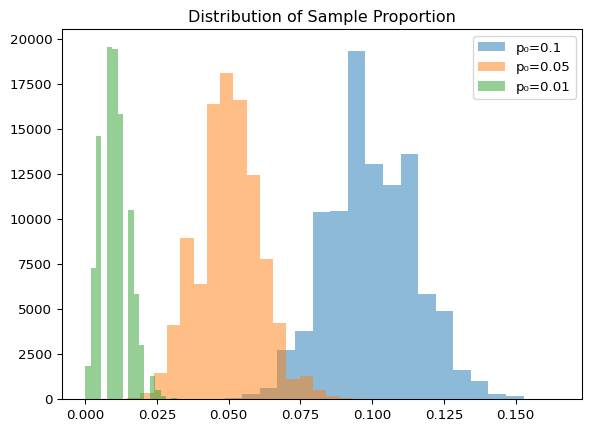

In [3]:
import numpy as np
import matplotlib.pyplot as plt

ps = [0.1, 0.05, 0.01]
N = 400
S = 100_000
for p in ps:
    Y = np.random.binomial(1, p, (S, N))
    Ybar = Y.mean(axis=1)
    plt.hist(Ybar, bins=20, alpha=0.5,
             label=f"p₀={p}")

plt.title("Distribution of Sample Proportion")
plt.legend()
plt.show()

## Exact Confidence Interval

-   Knowing distribution of $\hat{p}$ given $p$ can compute
    $P(|\hat{p}-p|\geq |\hat{p}_{obs} - p|)$ $$
    \widehat{CI}_\alpha(\hat{p}_{obs}) = \{p: P(|\hat{p}-p| \leq |\hat{p}_{obs} - p|) \leq \alpha \}
    $$

In [4]:
def proportioncisim(phat, n, level=0.95, S=100_000):
    se = (phat*(1-phat)/n)**0.5
    dp = se/20
    p = phat - dp
    while (abs(np.random.binomial(n,p, S)/n-p) <= abs((phat-p))).mean() < level :
        p = p - dp
        if p < 0:
            break
    plo = p
    p = phat + dp
    while (abs(np.random.binomial(n,p,S)/n-p) <= abs((phat-p))).mean() < level :
        p = p + dp
        if p < 0:
            break
    phi = p

    return(plo,phi)

phat = 0.05
n = 100
proportioncisim(phat, 100, level=0.95)

(0.024936331074641174, 0.10557596153014372)

## Exact Confidence Interval

In [5]:
import scipy
#| echo: true
def proportionci(phat, n, level=0.95):
    se = (phat*(1-phat)/n)**0.5
    dp = se/200
    k = round(phat*n)
    p = phat - dp
    while (scipy.stats.binom.cdf(k,n,p) < (1-(1-level)/2) ) :
        p = p - dp
        if (p < 0):
            break
    plo = p
    p = phat + dp
    while (scipy.stats.binom.cdf(k,n,p) > (1-level)/2) :
        p = p + dp
        if p < 0 :
            break
    phi = p
    return(plo,phi)

proportionci(phat, n)

(0.022320991708517042, 0.11287711726057285)

## Exact Confidence Interval

In [6]:
phat = pfizerall.NYT/pfizerall.NT
plo, phi=proportionci(phat,pfizerall.NT)
1000*plo, 1000*phi

(0.23971701200382992, 0.8556562725036012)

## Approximate Confidence Interval

-   Usually, distribution of data and/or estimator unknown
-   But a Central Limit Theorem can give an approximate distribution

## Central Limit Theorem

> **Berry-Esseen Central Limit Theorem**
>
> If $X_i$ are i.i.d. with $\Er[X] = 0$ and $\var(X)=1$, then $$
> \sup_{z \in \R} \left\vert
> P\left(\left[\frac{1}{\sqrt{n}} \sum_{i=1}^n X_i\right] \leq z \right) - \Phi(z) \right\vert \leq 0.5 \Er[|X|^3]/\sqrt{n}
> $$ where $\Phi$ is the normal CDF.

> **Multivariate Central Limit Theorem**
>
> If $X_i \in \R^d$ are i.i.d. with $\Er[X] = 0$ and $\var(X)=I_d$, then
> $$
> \sup_{A \subset \R^d, \text{convex}} \left\vert
> P\left(\frac{1}{\sqrt{n}} \sum_{i=1}^n X_i \in A \right) - P(N(0,I_d) \in A) \right\vert \leq
> (42 d^{1/4} + 16) \Er[\Vert X \Vert ^3]/\sqrt{n}
> $$
>
> [1]

## Approximate Confidence Interval

[1] See Raič (2019) for details.

In [7]:
def normalci(estimate, se, level=0.95):
    return (estimate + se*scipy.stats.norm.ppf((1-level)/2),
            estimate + se*scipy.stats.norm.ppf(1-(1-level)/2))

phat = pfizerall.NYT/pfizerall.NT
se = (phat*(1-phat)/pfizerall.NT)**0.5
lo,hi=normalci(phat, se)
lo*1000, hi*1000

(np.float64(0.1563452787741701), np.float64(0.7452324823077232))

In [8]:
def differenceci(e1,se1, e0, se0, level=0.95) :
    diff = e1 - e0
    se = (se1*se1 + se0*s0)**0.5
    return(normalci(diff, se, level=level))

p0 = pfizerall.NYU/pfizerall.NU
s0 = (p0*(1-p0)/pfizerall.NU)**0.5
lo,hi=differenceci(phat,se, p0, s0)
lo*1000, hi*1000

(np.float64(-9.218976095611334), np.float64(-6.63534540961651))

# Functions of Estimates

## Functions of Estimates

-   Often report functions of estimates
    -   E.g. $$
        \text{vaccine efficacy} = 1 - \frac{\Er[Y|T=1]} {\Er[Y|T=0]}
        $$

## Delta Method

> **Delta Method**
>
> If 1. $\sqrt{n} (\hat{\theta} - \theta_0) \leadsto N(0,\Omega)$
>
> 1.  $g: \R^k \to \R^m$ is continuously differentiable
>
> Then
> $\sqrt{n}(g(\hat{\theta}) - g(\theta_0)) \leadsto N\left(0, D(g)(\theta_0) \Omega D(g)(\theta_0) \right)'$

-   E.g. vaccine efficacy
    -   $\theta_0 = (\Er[Y|T=0], \Er[Y|t=1])$
    -   $g(\theta) = 1 - \theta_2/\theta_1$
    -   $D(g)(\theta_0) = \begin{pmatrix} \frac{\Er[Y|T=1]}{\Er[Y|T=0]^2} & -\frac{1}{\Er[Y|T=0]} \end{pmatrix}$
    -   $\Omega = \begin{pmatrix} p_0(1-p_0)/n_0 & 0 \\ 0 & p_1(1-p_1)/n_1 \end{pmatrix}$

## Delta Method

In [9]:
import torch

theta = [p0, phat]
Omega = np.matrix([[s0**2, 0], [0, se**2]])
def ve(theta) :
    return(1 - theta[1]/theta[0])

def deltamethod(g, theta, Omega) :
    x = torch.tensor(theta, requires_grad=True)
    val = g(x)
    val.backward()
    Dg = x.grad.numpy()
    return(Dg @ Omega @ Dg.transpose())

print(f"Efficacy among everyone is {ve(theta):.3} ({deltamethod(ve,theta,Omega)[0,0]**0.5:.2})")

Efficacy among everyone is 0.946 (0.018)

## Simulating Distribution of $g(\theta)$

-   Suppose $\sqrt{n} (\hat{\theta} - \theta_0) \leadsto N(0,\Omega)$
-   Create $\tilde{\theta}_s \sim N(\hat{\theta}, \Omega/n)$
    -   so $\sqrt{n}(\tilde{\theta}_s - \hat{\theta}) \sim N(0,\Omega)$
-   and
    $\sqrt{n}(g(\theta_{s}) - g(\hat{\theta})) \approx \sqrt{n}(g(\hat{\theta}) - g(\theta_0))$

## Simulated Distribution of Vaccine Efficacy

simulation se = 0.019

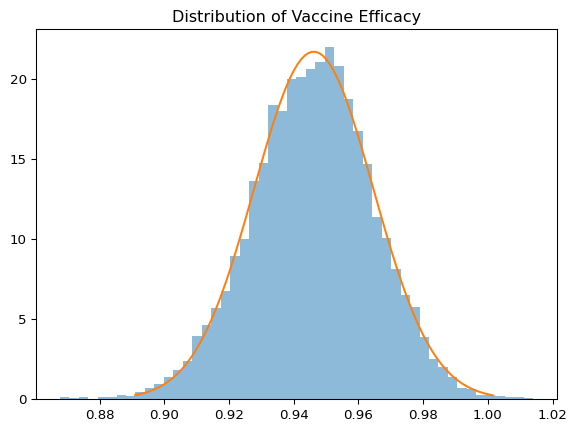

In [10]:
def simulateg(g,theta,Omega,S=10_000):
    thetas = np.random.multivariate_normal(theta, Omega, S)
    gs = np.apply_along_axis(g,1,thetas)
    return(gs, ((gs-g(theta))**2).mean())

gs, gv=simulateg(ve, theta, Omega)
print(f"simulation se = {gv**0.5:.2}")

plt.hist(gs, bins=50, alpha=0.5, density=True)
dse = deltamethod(ve,theta,Omega)[0,0]**0.5
z = np.linspace(-3,3,num=100)*dse + ve(theta)
fdeltamethod = scipy.stats.norm(loc=ve(theta), scale=dse).pdf
plt.plot(z, fdeltamethod(z))
plt.title("Distribution of Vaccine Efficacy")
plt.show()

# Bootstrap

## Bootstrap

-   Data $\{x_i\}_{i=1}^n$
-   Estimator $\hat{\theta}(\{x_i\}_{i=1}^n)$
    -   e.g. mean
        $\hat{\theta}(\{x_i\}_{i=1}^n) = \frac{1}{n} \sum_{i=1}^n x_i$
-   If we knew the distribution of $x$, we could calculate the
    distribution of $\hat{\theta}$

-   Bootstrap: use empirical distribution as estimate of unknown
    distribution of $x$

## Bootstrap

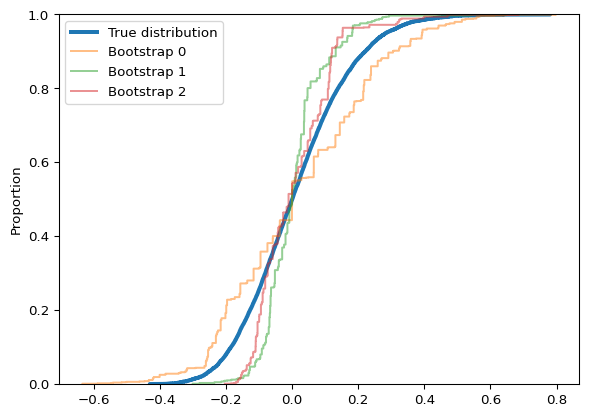

In [11]:
import seaborn as sns

def dgp(n):
    x = np.exp(abs(np.random.normal(0,1,n)))
    # x = np.random.normal(0,1,n)
    return x

def estimator(x):
    return np.median(x)

n = 100
S = 9999
# simulate true distribution of estimator
true = estimator(dgp(n*100_00))
mediansims = [estimator(dgp(n)) - true for _ in range(S)]

def bootstrap(data, estimator, B=999):
    n = len(data)
    est = estimator(data)
    bestimates = [estimator(np.random.choice(data,size=n, replace=True))-est for _ in range(B)]
    return bestimates

sns.ecdfplot(mediansims, label="True distribution", linewidth=3)
for b in range(3):
    sns.ecdfplot(bootstrap(dgp(n), estimator), alpha=0.5, label=f"Bootstrap {b}")
plt.legend()
plt.show()

## Bootstrap Confidence Interval

In [12]:
 def bootstrapci(data, estimator, B=999, level=0.95):
    estimates = bootstrap(data, estimator, B)
    lo = np.percentile(estimates, 100*(1-level)/2) + estimator(data)
    hi = np.percentile(estimates, 100*(1-(1-level)/2)) + estimator(data)
    return lo, hi

bootstrapci(dgp(n), estimator)

(np.float64(1.8046932709463748), np.float64(2.7160585473096885))

# Complications and Warnings

## Multiple Testing

-   If construct many confidence intervals, there is high change at
    least one will not contain the true parameter
    -   65% chance with twenty 95% confidence intervals
-   Trying many things and only focusing on “statistically significant”
    results only leads to spurious conclusions

## Dependence

-   Standard errors require assumptions limiting dependence
    -   Independent observations
    -   Not-too-dependent observations
        -   Clustered (for panel or grouped data)
        -   Stationary (for time series)
-   Bootstrap needs to be modified for dependence

## Pathological Parameter Values

-   Usual asymptotics (CLT, bootstrap, etc) don’t work if
    -   True parameter on boundary (e.g. variance = 0)
    -   True parameter near value where distribution of estimator
        discontinuous
        -   Weak instruments
        -   Unit root

## High Dimensions

-   Number of parameters ($p$) large compared to sample size ($n$)
-   Usual asymptotics break down
-   Risk of overfitting
-   Inference difficult, but possible
    -   Chernozhukov et al. (2024) chapter 4
-   More later …

## Sources and Further Reading

-   [Chapter
    3](https://matheusfacure.github.io/python-causality-handbook/03-Stats-Review-The-Most-Dangerous-Equation.html.html)
    of Facure (2022)
-   [Chapter 1](https://causalml-book.org/) of Chernozhukov et al.
    (2024)

## References

Chernozhukov, V., C. Hansen, N. Kallus, M. Spindler, and V. Syrgkanis.
2024. *Applied Causal Inference Powered by ML and AI*.
<https://causalml-book.org/>.

Facure, Matheus. 2022. *Causal Inference for the Brave and True*.
<https://matheusfacure.github.io/python-causality-handbook/landing-page.html>.

Raič, Martin. 2019. “<span class="nocase">A multivariate Berry–Esseen
theorem with explicit constants</span>.” *Bernoulli* 25 (4A): 2824–53.
<https://doi.org/10.3150/18-BEJ1072>.